# Alignment to ancestors pipeline in individual steps

The alignment-to-ancestors pipeline takes an alignment, finds the best phylogenetic model, builds a maximum-likelihood (ML) gene tree, reconciles this tree with the species tree, infers ancestral protein sequences, and then determines statistical supports for the existence of each ancestor.

We recommend performing the ancestral inference in a high-performance computing environment. Therefore, this Colab notebook serves as an example for the user to visualize the effects of manipulating parameters for ancestral reconstruction on a toy dataset without need for a computing cluster. See *03_alignment_to_ancestors_Colab.ipynb* to initiate the entire pipeline on a topiary's toy dataset with one code block.


<a href="https://colab.research.google.com/github/harmslab/topiary-examples/blob/main/04_alignment_to_ancestors_step_wise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Setup
Start by running the cells below to set up topiary and all required software.

In [ ]:
### THIS CELL SETS UP TOPIARY IN A GOOGLE COLAB ENVIRONMENT. 
### IF RUNNING THIS NOTEBOOK LOCALLY, IT MAY BE SAFELY DELETED

#@title Install software

#@markdown #### Installation requires two steps.

#@markdown 1. Install the software by pressing the _Play_ button on the left.
#@markdown Please be patient. This will take several minutes. <font color='teal'>
#@markdown After the  installation is complete, the kernel will reboot 
#@markdown and Colab will complain that the session crashed. This is normal.</font>
#@markdown <br/><br/>(If you wish to install raxml or generax, select the check boxes below. 
#@markdown These packages are only required for running the
#@markdown alignment-to-ancestors pipeline. Note: you can select
#@markdown the checkboxes and re-run this cell after doing the initial 
#@markdown installation.)

install_raxml = True #@param {type:"boolean"}
install_generax = True #@param {type:"boolean"}

#@markdown 2. After this cell runs, run the "Initialize environment" cell that follows.

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/harmslab/topiary-examples/main/notebooks/colab_installer.py",
                              "colab_installer.py")

    import colab_installer
    colab_installer.install_topiary(install_raxml=install_raxml,
                                    install_generax=install_generax)

  0%|          | 0/6 [00:00<?, ?it/s]

Download and install miniconda... Complete.
env: PYTHONSTARTUP=/contents/software/python_startup.py
Install conda packages... Complete.
Install pip packages... Complete.
Install raxml-ng... Complete.
Install generax... Complete.
Install topiary... 

In [ ]:
import topiary
import numpy as np
import pandas as pd 

### EVERYTHING AFTER THIS LINE IS IS USED TO SET UP TOPIARY IN A GOOGLE
### COLAB ENVIRONMENT. IF RUNNING THIS NOTEBOOK LOCALLY, THE LINES BELOW
### IN THIS CELL MAY BE SAFELY DELETED. 

#@title Initialize environment

#@markdown  Run this cell to initialize the environment after installation.
#@markdown (This cell can also be run if the kernel dies during a calculation,
#@markdown allowing you to reload modules without having to
#@markdown reinstall). 

#@markdown We recommend setting up a working directory on your google drive. This is a 
#@markdown convenient way to pass files to topiary and will allow you to save
#@markdown your work. For example, if you type `topiary_work` into the form
#@markdown field below, topiary will save all of its calculations in the 
#@markdown `topiary_work` directory in MyDrive (i.e. the top directory at
#@markdown https://drive.google.com). This script will create the directory if 
#@markdown it does not already exist. If the directory already exists, any files
#@markdown that are already in that directory will be available to topiary. You could, 
#@markdown for example, put a file called `seed.csv` in `topiary_work` and then
#@markdown access it as "seed.csv" in all cells below.
#@markdown <br/><br/>
#@markdown Note: Google may prompt you for permission to access the drive. 
#@markdown To work in a temporary colab environment, leave this blank. 

# Select a working directory on google drive
google_drive_directory = "rocket" #@param {type:"string"}

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    topiary._in_notebook = "colab"
    import colab_installer
    colab_installer.initialize_environment()
    colab_installer.mount_google_drive(google_drive_directory)

env: PYTHONPATH=""
env: PYTHONSTARTUP=/contents/software/python_startup.py
env: TOPIARY_MAX_SLOTS=1


# 00. Infer the evolutionary model

The first step in a maximum likelihood phylogenetic analysis is determining the maximum likelihood model of sequence evolution. This includes the matrix for amino acid substitution (i.e., LG, JTT, WAG, etc.), the stationary frequencies for that model, rate variation parameters (𝚪 distribution, rate categories, etc.), and the proportion of invariant sites. Topiary uses a conventional method to find the best model (Abascal F, 2005). It uses RAxML-NG to generate a maximum parsimony tree from the alignment. It then optimizes branch lengths and other parameters using all 360 combinations of these model parameters implemented in the computational library that underlies RAxML-NG and GeneRax. Finally, it ranks these models based on a corrected Akaike Information Criterion, which penalizes models with excess parameters to prevent overfitting.

Although this protocol is done automatically, topiary returns a variety of statistics including AIC, AICc, and BIC to help users who want more control over model selection. Via the API, users can also specify a custom input tree or a subset of the models to test. (Note: as of the current version, topiary excludes the LG4M and LG4X models, as these cause GeneRax to crash during gene-species tree reconciliation).


### Argument definitions and default parameters used in this step:

**df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.

**starting_tree** : *str, optional*
<br> Tree in newick format. This will be used for the best model inference and starting tree for the maximum likelihood tree estimation. If not specified, the maximum parsimony tree is generated and used.

**model_matrices** : *list, default=["cpREV","Dayhoff","DCMut","DEN","Blosum62","FLU","HIVb","HIVw","JTT","JTT-DCMut","LG","mtART","mtMAM","mtREV","mtZOA","PMB","rtREV","stmtREV","VT","WAG"]*
<br> List of model matrices to check. If calling from command line, these can be specified directly (`--model_matrices LG ...`) or by specifying a file with models on each line (`--model_matrices SOME_FILE`).

**model_rates** : *list, default=["","G8"]*
<br> Ways to treat model rates. If calling from command line, these can be specified directly (`--model_rates G8 ...`) or by specifying a file with rates on each line (`--model_rates SOME_FILE`).

**model_freqs** : *list, default=["","FC","FO"]*
<br> Ways to treat model freqs. If calling from command line, these can be specified directly (`--model_freqs FC FO ...`) or by specifying a file with freqs on each line (`--model_freqs SOME_FILE`).

**model_invariant** : *list, default=["","IC","IO"]*
<br> Ways to treat invariant alignment columns. If calling from command line, these can be specified directly (`--model_invariant IC IO ...`) or by specifying a file with invariants on each line (`--model_invariant SOME_FILE`).

**calc_dir** : *str*
<br> Name of the output directory to capture the results of this calculation in.

**num_threads** : *int, default=-1*
<br> Number of threads to use. if -1 use all available.

**raxml_binary** : *str, optional*
<br> RAxML binary to use.


**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with
overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. Incompatible with restart.

In [ ]:
#@title Find the best phylogenetic model

#@markdown This cell takes the alignment and finds the best evolutionary model
#@markdown to explain relationships of sequences in the alignment. The output
#@markdown from this cell shows the comparison of all 360 combinations of
#@markdown defined model parameters conducted to find the best model.
#@markdown 
#@markdown The following parameters can be manipulated.


df = pd.read_csv("software/topiary/tests/data/tiny-phylo/00_find-best-model/input/dataframe.csv")

calculation_directory="00_find-model" #@param {type: "string"}
starting_tree=None #@param {type: "string"}
model_matrices=["cpREV","Dayhoff","DCMut","DEN","Blosum62","FLU","HIVb","HIVw","JTT","JTT-DCMut","LG","mtART","mtMAM","mtREV","mtZOA","PMB","rtREV","stmtREV","VT","WAG"] #@param {type: "string"} XX should this be ["LG","JTT"]?
model_rates=["","G8"] #@param {type: "string"} XX should this be none?
model_freqs=["","FC","FO"] #@param {type: "string"} XXshould this be none?
model_invariant=["","IC","IO"] #@param {type: "string"}
#restart=False #@param {type: "boolean"}
overwrite=True #@param {type: "boolean"}

topiary.find_best_model(df=df,
                        gene_tree=starting_tree,
                        #seed=12345,
                        model_matrices=model_matrices,
                        model_rates=model_rates,
                        model_freqs=model_freqs,
                        model_invariant=model_invariant,
                        calc_dir=calculation_directory,
                        num_threads=-1,
                        #raxml_binary=raxml_binary,
                        #restart=restart,
                        overwrite=overwrite)



----------------------------------------------------------------------

topiary is starting a find_best_model calculation in ./00_find-model:


Generating maximum parsimony tree.

Launching raxml-ng, 0:00:00.008856 (H:M:S)
Constructing set of possible models.
Testing 360 models.
, 0:00:00.039109 (H:M:S)


  0%|          | 0/360 [00:00<?, ?it/s]


Top 10 models:

               model           AICc prob
               rtREV               0.858
                 PMB               0.051
                 DEN               0.044
            Blosum62               0.016
                 WAG               0.013
                  LG               0.009
                  VT               0.008
           JTT-DCMut               0.001
                 JTT               0.000
               DCMut               0.000


topiary ran a find_best_model calculation in ./00_find-model:

+ Completed in 0:00:33.729463 (H:M:S)
+ Wrote results to ./00_find-model/output

----------------------------------------------------------------------




# 01. Build a maximum likelihood gene tree

Topiary next infers an ML gene tree using the inferred phylogenetic model with the default RAxML-NG settings for the “--search” protocol. This starts the inference from 10 random trees and 10 different parsimony trees. It then optimizes the tree topology using an SPR subtree cutoff of 1, with an automatically selected fast versus slow SPR radius. Branch lengths are optimized using the NR-FAST algorithm. The tree with the highest likelihood is selected and used for downstream analyses. Advanced users have full access to all RAxML-NG options XXX.

### Argument definitions and default parameters used in this step:

**prev_calculation** : *str*
<br> Use the results directory of the previous calculation ("calc_dir") as input for this call.

**calc_dir** : *str*
<br> Name of the output directory to capture the results of this calculation in.

**num_threads** : *int, default=-1*
<br> Number of threads to use. If -1 use all available.

**raxml_binary** : *str, optional*
<br> RAxML binary to use.

**no_bootstrap** : *bool, default=False*
<br> Do not do bootstrap replicates if set to True.

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with
overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. Incompatible with restart.


----------------------------------------------------------------------

topiary is starting a ml_tree calculation in ./01_ml-tree:

Launching raxml-ng, 0:00:00.004745 (H:M:S)
Running '/usr/local/bin/raxml-ng --search --msa alignment.phy --model rtREV --seed 7994435789 --threads auto{2}'


topiary ran a ml_tree calculation in ./01_ml-tree:

+ Completed in 0:00:01.025536 (H:M:S)
+ Wrote results to ./01_ml-tree/output

----------------------------------------------------------------------




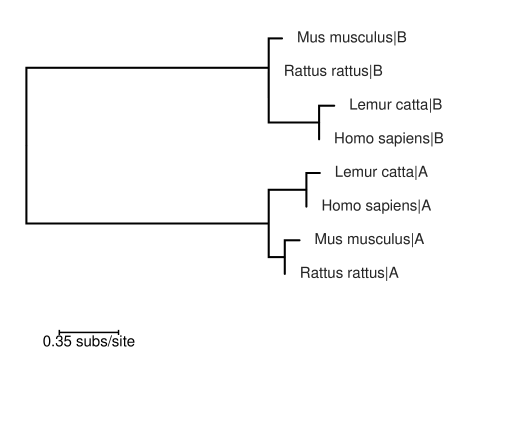

In [ ]:
#@title Generate the maximum likelihood tree

#@markdown This cell builds a maximum likelihood tree using the best model found 
#@markdown in the previous step.
#@markdown 
#@markdown The input and output directories and location of the summary tree
#@markdown PDF for this step are listed here. The summary tree is shown as the
#@markdown output after running this cell.

previous_directory="00_find-model" #@param {type: "string"}
calculation_directory="01_ml-tree" #@param {type: "string"}
summary_tree="01_ml-tree/output/summary-tree.pdf" #@param {type: "string"}
#restart=False #@param {type: "boolean"}
overwrite=False #@param {type: "boolean"}

topiary.generate_ml_tree(prev_calculation=previous_directory,
                        calc_dir=calculation_directory,
                        num_threads=-1,
                        #raxml_binary=RAXML_BINARY,
                        bootstrap=False,
                        #restart=restart,
                        overwrite=overwrite)


# 02. Reconcile gene and species trees

The next step in the pipeline is to reconcile the gene tree with the species tree. This automatically roots the tree and has been shown to improve the quality of reconstructed sequences (Groussin M, 2015). For this purpose, we use GeneRax, a new high-performance program for reconciling gene and species trees. Unlike other, heuristic, methods, GeneRax uses an explicit likelihood framework (Morel B, 2020). The final tree is the maximum likelihood estimate for an evolutionary model that includes both sequence evolution (i.e., LG) and evolutionary events (speciation, duplication, loss, and lateral gene transfer).

To do this, topiary uses the ML evolutionary model and ML gene tree inferred previously as inputs to GeneRax. For the rooted species tree, topiary automatically downloads the most recent synthetic tree from the Open Tree of Life (OTL) database (Rees J, 2017; Mctavish EJ, 2021). (Previous steps in the pipeline ensure that all sequences that have made it to this step come from species that are present in the OTL database). Any polytomies in this tree are resolved arbitrarily prior to the reconciliation inference. Topiary runs GeneRax with the default parameters and the UndatedDL model (Morel B, 2020). The UndatedDL model accounts for duplication and loss events. Topiary users can select the other implemented model— UndatedDTL, which allows lateral transfer if they anticipate lateral gene transfer occurs for their gene of interest. 

The resulting tree is a maximum likelihood reconciled gene-species tree with optimized branch lengths and nodes labeled with inferred evolutionary events (speciation, duplication, or transfer). GeneRax returns a variety of other outputs that are made accessible to topiary users, but only the reconciled tree is used further in the pipeline.

### Argument definitions and default parameters used in this step:

**prev_calculation** : *str*
<br> Use the results directory of the previous calculation ("calc_dir") as input for this call.

**calc_dir** : *str*
<br> Name of the output directory to capture the results of this calculation in.

**no_horizontal_transfer** : *bool, default=False* 
<br> Whether to allow horizontal transfer during reconciliation. Default is to allow transfer (UndatedDTL; recommended). If flat set, use UndatedDL model.

**generax_binary** : *str, optional*
<br> What generax binary to use.

**num_threads** : *int, default=-1*
<br> Number of threads to use. if -1 use all available.

**no_bootstrap** : *bool, default=False* 
<br> Do not do bootstrap replicates if set to True.

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with
overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. Incompatible with restart.


----------------------------------------------------------------------

topiary is starting a reconcile calculation in ./02_reconciliation:

Setting up reconciliation directory, 0:00:00.007168 (H:M:S)
launching generax, 0:00:00.040680 (H:M:S)
Running '/usr/local/bin/generax --families control.txt --species-tree species_tree.newick --prefix result --rec-model UndatedDTL --seed 7994435789'


topiary ran a reconcile calculation in ./02_reconciliation:

+ Completed in 0:00:01.063550 (H:M:S)
+ Wrote results to ./02_reconciliation/output

----------------------------------------------------------------------




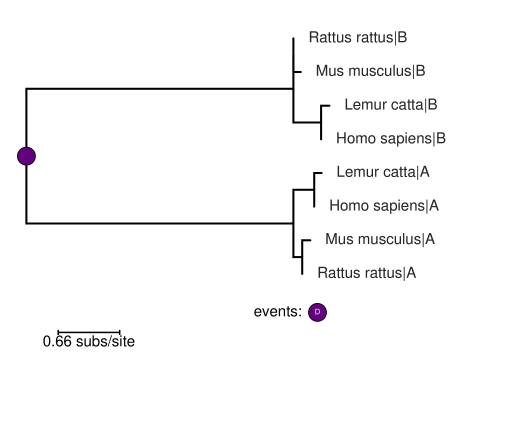

In [ ]:
#@title Reconcile the ML gene tree with species tree

#@markdown This cell uses GeneRax software to improve the likelihood of the final
#@markdown topology of the gene tree by reconciling the ML gene with the species
#@markdown tree. GeneRax will only make changes to the ML gene tree if the
#@markdown current topology requires a complicated series of evolutionary steps
#@markdown relating sequences that could be more easily explained if the
#@markdown topology matched the species tree.
#@markdown 
#@markdown If reconstructing microbe-specific ancestral proteins, reconciling
#@markdown your gene tree with the species tree might not improve the confidence
#@markdown in the final tree. In this case, you can skip the reconciliation steps
#@markdown in the single line pipeline by flagging --no_reconcile=True
#@markdown 
#@markdown The input and output directories and location of the summary tree
#@markdown PDF for this step are listed here. The summary tree is shown as the
#@markdown output after running this cell.

previous_calculation="01_ml-tree" #@param {type: "string"}
calculation_directory="02_reconciliation" #@param {type: "string"}
summary_tree="02_reconciliation/output/summary-tree.pdf"  #@param {type: "string"}

#@markdown The following parameters can be manipulated.
allow_horizontal_transfer=True #@param {type: "boolean"}
#restart=False #@param {type: "boolean"}
overwrite=False #@param {type: "boolean"}

species_tree = "software/topiary/tests/data/tiny-phylo/initial-input/species-tree.newick"

topiary.reconcile(prev_calculation=previous_calculation,
                  calc_dir=calculation_directory,
                  species_tree=species_tree,
                  allow_horizontal_transfer=allow_horizontal_transfer,
                  #generax_binary=GENERAX_BINARY,
                  num_threads=1, #num_threads, XXX HACK HACK HACK
                  bootstrap=False,
                  #restart=restart,
                  overwrite=overwrite)


# 03. Reconstruct ancestors

The next step is to infer sequences of ancestral nodes on the reconciled gene-species tree. For this, we use RAxML-NG, which implements a standard marginal ancestral reconstruction method (Yang Z, 1995). (This differs from previous versions of RAxML, which used a non- standard reconstruction method that was not comparable to other approaches). RAxML-NG finds the amino acid at each site in each ancestor that maximizes the likelihood of observing the sequence alignment given the tree, branch lengths, and phylogenetic model. This returns a matrix of posterior probabilities for each amino acid at each site in the alignment for each ancestral node. Topiary extracts the sequence of the maximum likelihood ancestor, as well as the so-called altAll version of the ancestor that incorporates alternate reconstructed amino acids at ambiguous positions. It uses a default cutoff of 0.25 to identify ambiguous sites (Eick GN, 2016); this can be set by the user.

The evolutionary models used by RAxML-NG do not explicitly treat gaps; therefore, the first draft of the reconstructed ancestor will be ungapped. Topiary assigns gaps by treating them as characters during ancestral character reconstruction (ACR). For this purpose, topiary uses the DOWNPASS (Maddison DR, 2000) algorithm as implemented by the PastML package (Ishikawa SA, 2019). The final output for this step consists of the gapped sequences of the maximum likelihood and altAll ancestors for each node. These have associated statistical supports: posterior probabilities for each reconstructed amino acid and support for gaps. Topiary also puts out a variety of summary graphs to help select high quality sequences.


### Argument definitions and default parameters used in this step:

**prev_calculation** : *str*
<br> Use the results directory of the previous calculation ("calc_dir") as input for this call.

**calc_dir** : *str*
<br> Name of the output directory to capture the results of this calculation in.

**num_threads** : *int, default=-1*
<br> Number of threads to use. if -1 use all available.

**alt_cutoff** : *float, default=0.25*
<br> Cutoff to use for altAll alternate ancestral protein sequence generation. Should be between 0 and 1.

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with
overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. Incompatible with restart.


----------------------------------------------------------------------

topiary is starting a ancestors calculation in ./03_ancestors:

Reconstructing ancestral states.

Launching raxml-ng, 0:00:00.008640 (H:M:S)
parsing ancestral output, 0:00:00.035586 (H:M:S)


topiary ran a reconcile_ancestors calculation in ./03_ancestors:

+ Completed in 0:00:01.707952 (H:M:S)
+ Wrote results to ./03_ancestors/output

----------------------------------------------------------------------




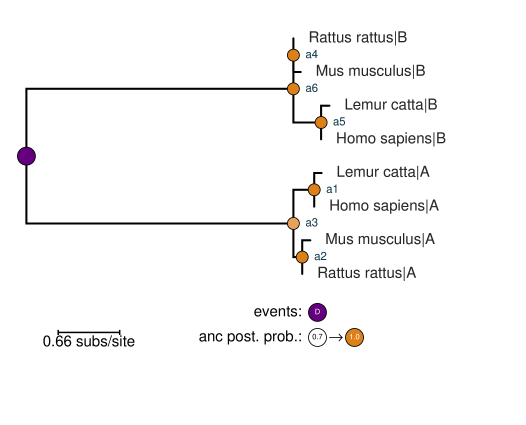

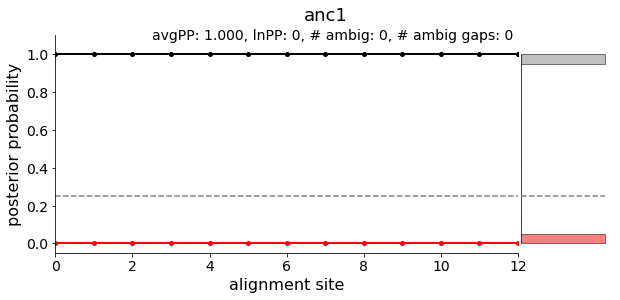

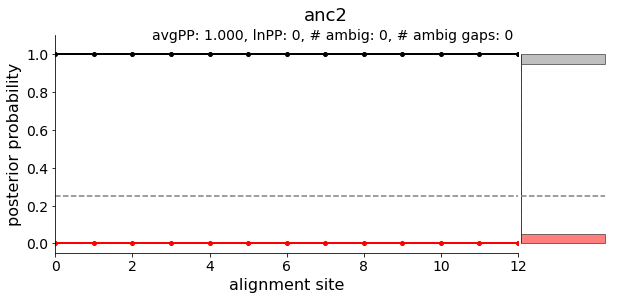

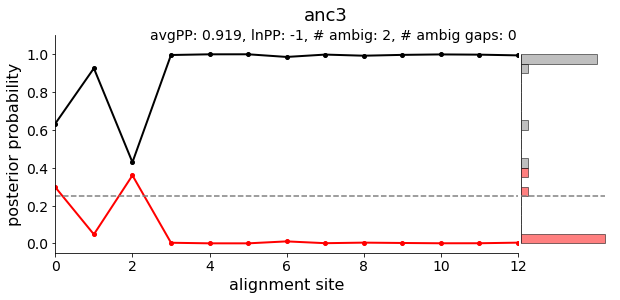

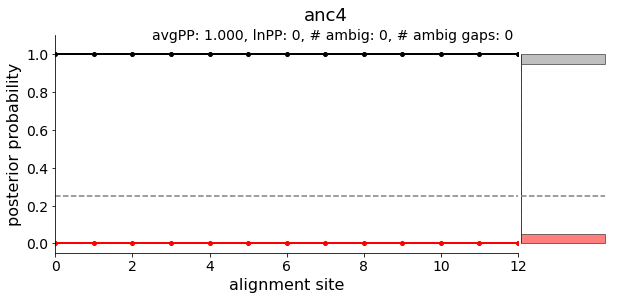

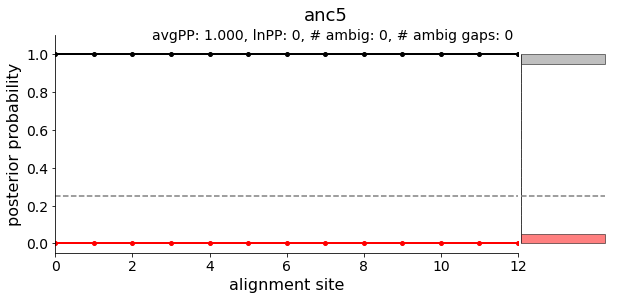

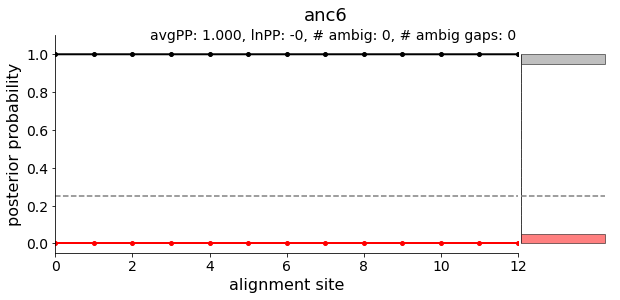

In [ ]:
#@title Generate ancestors

#@markdown Infers ancestral proteins.
#@markdown 
#@markdown The input and output directories and location of the summary tree
#@markdown PDF for this step are listed here. The summary tree is shown as the 
#@markdown output for this cell.

prev_calculation="02_reconciliation" #@param {type: "string"}
calc_dir="03_ancestors" #@param {type: "string"}

summary_tree="03_ancestors/output/summary-tree.pdf"  #@param {type: "string"}

#@markdown The following parameters can be manipulated.

alt_cutoff=0.25 #@param {type: "number"}
#restart=False #@param {type: "boolean"}
overwrite=False #@param {type: "boolean"}

topiary.generate_ancestors(prev_calculation=prev_calculation,
                          calc_dir=calc_dir,
                          num_threads=1,
                          alt_cutoff=alt_cutoff,
                          #restart=restart,
                          overwrite=overwrite)


# Assess posterior probabilities for individual ancestral sequences

It is useful to visualize ancestral sequence posterior probabilities (PP) in detail at this stage (see output from the cell above). In particular, it is important to check ancestral sequences with low average posterior probability labels in the summary tree. Regions where the ML and altAll constructions have similar posterior probability represent amino acids in the protein sequence that are highly ambiguous given the multiple sequence alignment. Generally, we recommend moving forward with ancestors with high (>0.85) PP. However, functionally competent ancestors have been resurrected from reconstructions with an average PP > 0.75.

Assess if there is enough statistical support for the reconstructed amino acid sequence for the lowly supported ancestors. If there is not enough support, it may be beneficial to add more sequences to the multiple sequence alignment that would provide additional sequence signal for this particular ancestor.

In [ ]:
#@title View amino acid-level statistical support for ancestral sequences (optional) 

#@markdown The ancestor-data.csv file
#@markdown shows posterior probability values calculated for the
#@markdown maximum likelihood and next most likely amino acid
#@markdown (or alternate state) at each site along the reconstructed
#@markdown ancestral sequences. The location of the file is shown
#@markdown below and its contents can be viewed by running the cell.

ancestor_data="03_ancestors/output/reconciled-tree_ancestors/ancestor-data.csv" #@param {type: "string"}

df = pd.read_csv(ancestor_data)
df

,Unnamed: 0,anc,site,gap,ml_state,ml_pp,alt_state,alt_pp,site_type,entropy
0,0,anc1,0,False,A,1.00000,A,0.0,good,0.00000
1,1,anc1,1,False,G,1.00000,A,0.0,good,0.00000
2,2,anc1,2,False,Q,1.00000,A,0.0,good,0.00000
3,3,anc1,3,False,R,1.00000,A,0.0,good,0.00000
4,4,anc1,4,False,W,1.00000,A,0.0,good,0.00000
...,...,...,...,...,...,...,...,...,...,...
73,73,anc6,8,False,K,1.00000,A,0.0,good,0.00000
74,74,anc6,9,False,L,1.00000,A,0.0,good,0.00000
75,75,anc6,10,False,Q,1.00000,A,0.0,good,0.00000
76,76,anc6,11,False,H,1.00000,A,0.0,good,0.00000


# 04. Branch supports

To determine branch supports, topiary uses non-parametric bootstrapping (Felsenstein J, 1985). Briefly, RAxML-NG generates pseudoreplicate alignments by sampling columns, with replacement, from the input alignment. RAxML-NG then infers an evolutionary tree for each of these alignments. Topiary generates up to 1,000 bootstrap pseudoreplicates, using RAxML- NG’s automatic Extended Majority Rules (autoMRE) method with a cutoff of 0.03 to determine the exact number. The output from RAxML-NG is a collection of pseudoreplicate alignments and pseudoreplicate gene trees. Because we are reconstructing ancestors on the reconciled tree, we pass each pseudoreplicate alignment and gene tree into GeneRax for gene-species tree reconciliation, yielding a final collection of pseudoreplicate reconciled trees. Topiary then uses RAxML-NG to map these pseudoreplicate trees onto the ML reconciled tree as branch supports. Topiary also assesses convergence for the branch support estimate using the “--bsconverge” option.


### Argument definitions and default parameters used in this step:

**prev_calculation** : *str*
<br> Use the results directory of the previous calculation ("calc_dir") as input for this call.

**calc_dir** : *str*
<br> Name of the output directory to capture the results of this calculation in.

**num_threads** : *int, default=-1*
<br> Number of threads to use. if -1 use all available.

**raxml_binary** : *str, optional*
<br> RAxML binary to use.

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with
overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. Incompatible with restart.


----------------------------------------------------------------------

topiary is starting a ml_bootstrap calculation in ./04_bootstraps:

Launching raxml-ng, 0:00:00.005815 (H:M:S)
Running '/usr/local/bin/raxml-ng --bootstrap --msa alignment.phy --tree tree.newick --model rtREV --seed 7994435789 --threads 2 --bs-trees autoMRE --bs-write-msa'

RAxML-NG v. 1.1.0 released on 29.11.2021 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) CPU @ 2.20GHz, 1 cores, 12 GB RAM

RAxML-NG was called at 08-Dec-2022 02:04:59 as follows:

/usr/local/bin/raxml-ng --bootstrap --msa alignment.phy --tree tree.newick --model rtREV --seed 7994435789 --threads 2 --bs-trees autoMRE --bs-write-msa

Analysis options:
  run 

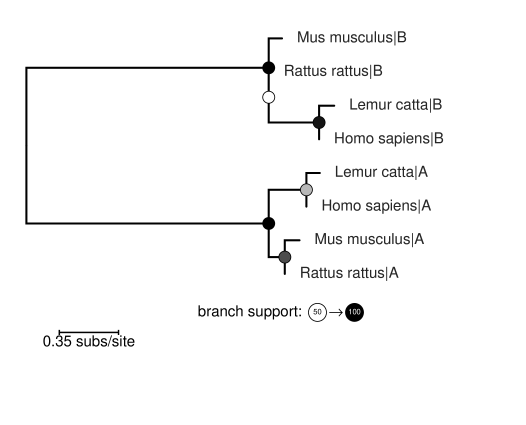

In [ ]:
#@title Determine statistical supports for the existence of each reconstructed ancestor

#@markdown This step first reconciles each bootstrap pseudoreplicate ML gene tree. 
#@markdown It then calculates branch support values from the frequencies of seeing
#@markdown the same ancestral nodes found in the species-reconciled ML gene tree.
#@markdown
#@markdown The input and output directories and location of the summary tree
#@markdown PDF for this step are listed here. The final summary tree including 
#@markdown reconstructed ancestors labeled with branch support and average 
#@markdown ML sequence posterior probability is shown as the output for this cell.

previous_calculation="03_ancestors" #@param {type: "string"}
calculation_directory="04_bootstraps" #@param {type: "string"}

summary_tree="04_bootstraps/output/summary-tree.pdf"  #@param {type: "string"}

#@markdown The following parameters can be manipulated if you have run this 
#@markdown cell before.
#restart=False #@param {type: "boolean"}
overwrite=False #@param {type: "boolean"}

topiary.generate_bootstraps(prev_calculation=previous_calculation,
                            calc_dir=calculation_directory,
                            num_threads=-1,
                            #raxml_binary=RAXML_BINARY,
                            #restart=restart,
                            overwrite=overwrite)



See the "Selecting ancestors" section of the Colab notebook "03_alignment_to_ancestors_Colab.ipynb" for a detailed description of how to determine if a particular ancestral sequence has reasonable statistical support to have existed. Such ancestors can be resurrected and functional characterized.